# Investigating Ranks
In the first section, I am going to investigate what an appropriate rank to consider should be. It will make sense to look at the 
ranks of a trained matrix and a randomly initialized matrix. We will start by looking at a randomly initialized matrix and then
look at a trained matrix. Specifically, I will look at the rank of a randomly initialized matrix. I will need to consider the sizes 
that are seen in RoBERTa

## Imports and Helper Functions

In [1]:
# Import Appropriate Libraries
%load_ext autoreload
    
import torch
import matplotlib.pyplot as plt 
import bisect
import sys
sys.path.append("../")

In [2]:
def get_principle_direction(A, exp_var):
    U, S, V = torch.linalg.svd(A)
    X = (torch.cumsum(S, 0) / S.sum().item()).tolist()
    num = bisect.bisect(X, exp_var)
    return num

## Normally Initialized Matrix Analysis

In [4]:
def plot_results(n=100, size=[768, 768], exp_var=0.99):
    results = []
    for _ in range(n):
        A = torch.randn(size)
        num = get_principle_direction(A, exp_var)
        results.append(num)
    return results

(array([51.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 49.]),
 array([515. , 515.1, 515.2, 515.3, 515.4, 515.5, 515.6, 515.7, 515.8,
        515.9, 516. ]),
 <BarContainer object of 10 artists>)

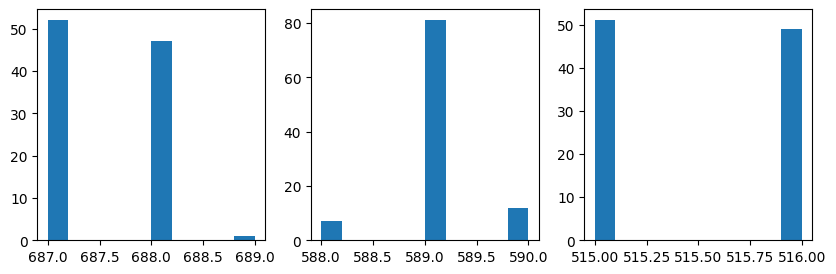

In [6]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
ax[0].hist(plot_results())
ax[1].hist(plot_results(exp_var=0.95))
ax[2].hist(plot_results(exp_var=0.9))

The above results indicate the rank is very tightly distributed based on the explained variance. The reader is encouraged to play with the explained_variance and support the claim themselves.

## Analysis of RoBERTa pre-trained Weights 

In [3]:
## Now let's look at how tightly the weights are distributed in RoBERTa 
roberta_large = torch.hub.load('pytorch/fairseq', 'roberta.large') 
roberta_base = torch.hub.load('pytorch/fairseq', 'roberta.base')

Using cache found in /home/mathadoor/.cache/torch/hub/pytorch_fairseq_main
INFO:fairseq.tasks.text_to_speech:Please install tensorboardX: pip install tensorboardX
DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): dl.fbaipublicfiles.com:80
DEBUG:urllib3.connectionpool:http://dl.fbaipublicfiles.com:80 "HEAD /fairseq/models/roberta.large.tar.gz HTTP/1.1" 200 0
INFO:fairseq.file_utils:loading archive file http://dl.fbaipublicfiles.com/fairseq/models/roberta.large.tar.gz from cache at /home/mathadoor/.cache/torch/pytorch_fairseq/83e3a689e28e5e4696ecb0bbb05a77355444a5c8a3437e0f736d8a564e80035e.c687083d14776c1979f3f71654febb42f2bb3d9a94ff7ebdfe1ac6748dba89d2
/home/mathadoor/Documents/peft-study/venv/lib/python3.10/site-packages/hydra/experimental/initialize.py:43: UserWarning: hydra.experimental.initialize() is no longer experimental. Use hydra.initialize()
  deprecation_warning(message=message)
/home/mathadoor/Documents/peft-study/venv/lib/python3.10/site-packages/hydra/experime

In [4]:
def print_principle_direction(model, exp_var):
    for key, param in model.named_parameters():
        with torch.no_grad():
            key = ".".join(key.split(".")[3:])
            p_size = min(param.size())
            if len(param.size()) < 2:
                continue
            print(key, get_principle_direction(param, exp_var), p_size)

In [7]:
explained_variance = 0.99
print("# Roberta Base Principle Directions \n")
print_principle_direction(roberta_base, explained_variance)

print("\n# Roberta Large Principle Directions \n")
print_principle_direction(roberta_large, explained_variance)

# Roberta Base Principle Directions 

embed_tokens.weight 745 768
embed_positions.weight 439 514
layers.0.self_attn.k_proj.weight 652 768
layers.0.self_attn.v_proj.weight 667 768
layers.0.self_attn.q_proj.weight 653 768
layers.0.self_attn.out_proj.weight 669 768
layers.0.fc1.weight 748 768
layers.0.fc2.weight 748 768
layers.1.self_attn.k_proj.weight 649 768
layers.1.self_attn.v_proj.weight 665 768
layers.1.self_attn.q_proj.weight 644 768
layers.1.self_attn.out_proj.weight 662 768
layers.1.fc1.weight 745 768
layers.1.fc2.weight 746 768
layers.2.self_attn.k_proj.weight 639 768
layers.2.self_attn.v_proj.weight 661 768
layers.2.self_attn.q_proj.weight 638 768
layers.2.self_attn.out_proj.weight 662 768
layers.2.fc1.weight 744 768
layers.2.fc2.weight 744 768
layers.3.self_attn.k_proj.weight 649 768
layers.3.self_attn.v_proj.weight 660 768
layers.3.self_attn.q_proj.weight 649 768
layers.3.self_attn.out_proj.weight 656 768
layers.3.fc1.weight 745 768
layers.3.fc2.weight 744 768
layers.4.self_a

On the surface, the above results suggest you need most of the directions to account for the explained variance in the parameters.
As such, we finetune the models for SQuAD and review the difference in the weights of the base and the tuned model. If the difference has 
fewer principle directions with high explanation, it would mean it is possible the task-based fine-tuning can be done in a smaller subspace. 

## Rank Variation During Training

In [24]:
# Get Dataset
import hydra
from omegaconf import DictConfig, OmegaConf
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.optim import AdamW
from torch.nn import CrossEntropyLoss
from train.train import train_epoch
from utils.metrics import AverageMeter

In [10]:
# Extract Training Configuration
with hydra.initialize(version_base=None, config_path="../config"):
    cfg = hydra.compose(config_name="app_config")

DEBUG:hydra.core.utils:Setting JobRuntime:name=notebook


In [19]:
train_dataset = load_dataset("squad", split="train")
val_dataset = load_dataset("squad", split="validation")

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/squad HTTP/1.1" 307 64
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/rajpurkar/squad HTTP/1.1" 200 2859
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): s3.amazonaws.com:443
DEBUG:urllib3.connectionpool:https://s3.amazonaws.com:443 "HEAD /datasets.huggingface.co/datasets/datasets/squad/squad.py HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/squad HTTP/1.1" 307 64
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/datasets/rajpurkar/squad HTTP/1.1" 200 2859
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): huggingface.co:443
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /datasets/squad/resolve/7b6d24c440a36b6815f21b70d25016731768db1f/README.md HTTP/1.1" 307 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /datasets/rajpurkar/squad/resolve/7b6d24c440a36b6815f21b70d2501

In [28]:
## Create Training Artifacts
training_cfg = hydra.utils.instantiate(cfg.model.model.train)

train_loader = DataLoader(train_dataset, batch_size=training_cfg.batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=training_cfg.batch_size)

model = roberta_base
optimizer = AdamW(params=model.parameters(), lr=training_cfg.lr, weight_decay=training_cfg.weight_decay)
criterion = CrossEntropyLoss()

loss_meter = AverageMeter()
acc_meter = AverageMeter()

# Introducing LoRA Weights
This section introduces LoRA weights in our models for further analysis.

In [3]:
# On the surface the above results suggest you need most of the directions to account for most of the directions. 
# It will be useful to see which directions are affected and how later.
from models.LoRA import LoRALinearLayer
def add_linear_lora(module, rank, init_type=0):
    for key, child in module.named_children():
        if isinstance(child, torch.nn.Linear):
            lora_layer =  LoRALinearLayer(child, rank=rank, init_type=init_type)
            setattr(module, key, lora_layer)
        else:
            add_linear_lora(child, rank, init_type)

In [4]:
add_linear_lora(roberta_base, rank=10, init_type=1)

In [5]:
roberta_base

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50265, 768, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 768, padding_idx=1)
        (layernorm_embedding): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0-11): 12 x TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (v_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (q_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
              (out_proj): LoRALinear(in_features=768, in_features=768, rank=$10, init_type=$1)
            )
            (self_attn_layer_norm): LayerNorm

In [6]:
roberta_large

RobertaHubInterface(
  (model): RobertaModel(
    (encoder): RobertaEncoder(
      (sentence_encoder): TransformerEncoder(
        (dropout_module): FairseqDropout()
        (embed_tokens): Embedding(50265, 1024, padding_idx=1)
        (embed_positions): LearnedPositionalEmbedding(514, 1024, padding_idx=1)
        (layernorm_embedding): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (layers): ModuleList(
          (0-23): 24 x TransformerEncoderLayerBase(
            (self_attn): MultiheadAttention(
              (dropout_module): FairseqDropout()
              (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
            )
            (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
       